In [1]:
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')

# !pip install git+https://github.com/SelfExplainML/Aletheia.git

# Load data and Train ReLU DNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
random_state = 0
data = load_boston()
x = MinMaxScaler().fit_transform(data.data)
y = MinMaxScaler().fit_transform(data.target.reshape(-1, 1))
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [3]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=[20] * 2, max_iter=2000, early_stopping=True, 
                   n_iter_no_change=100, validation_fraction=0.2,
                   solver='adam', activation="relu", random_state=random_state,
                   learning_rate_init=0.001)
mlp.fit(train_x, train_y)

MLPRegressor(early_stopping=True, hidden_layer_sizes=[20, 20], max_iter=2000,
             n_iter_no_change=100, random_state=0, validation_fraction=0.2)

# Run UnwrapperRegressor in Aletheia

In [4]:
from aletheia import *
clf = UnwrapperRegressor(mlp.coefs_, mlp.intercepts_)
clf.fit(train_x, train_y)

In [5]:
clf.summary()

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,20.0,0.216667,0.056409,0.002481,0.036408
1,17.0,0.465359,0.102063,0.003447,0.098258
2,14.0,0.137778,0.061061,0.002398,0.111933
3,12.0,0.167593,0.056426,0.001435,0.031279
4,12.0,0.331111,0.052266,0.000367,0.026821
...,...,...,...,...,...
150,1.0,0.317778,0.000000,0.000070,0.056758
151,1.0,0.188889,0.000000,0.000050,0.043684
152,1.0,0.342222,0.000000,0.001068,0.036494
153,1.0,0.235556,0.000000,0.000216,0.058816


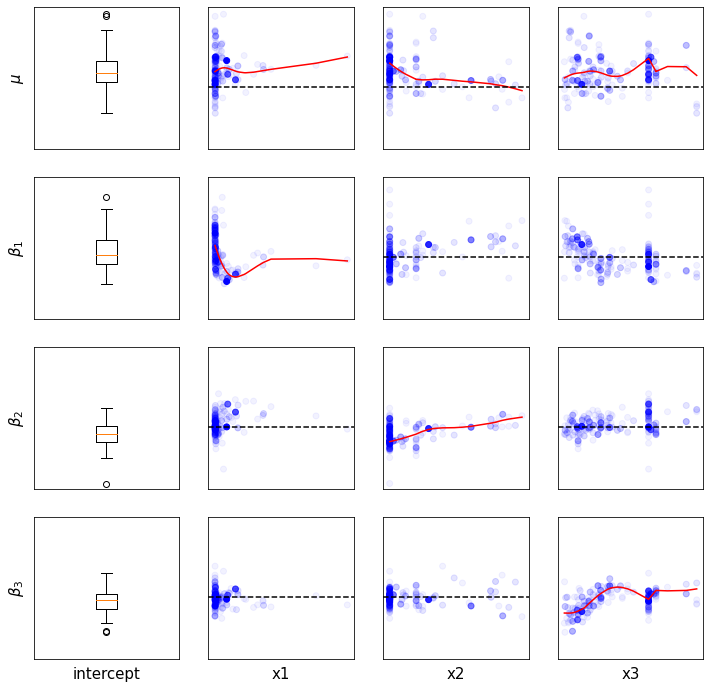

In [6]:
clf.pair_plot([0, 1, 2, 3], nllms=clf.nllms)

Percentage of Pure LLMs 

In [7]:
len(np.where(clf.ystd_llms == 0)[0]) / clf.nllms

0.5290322580645161

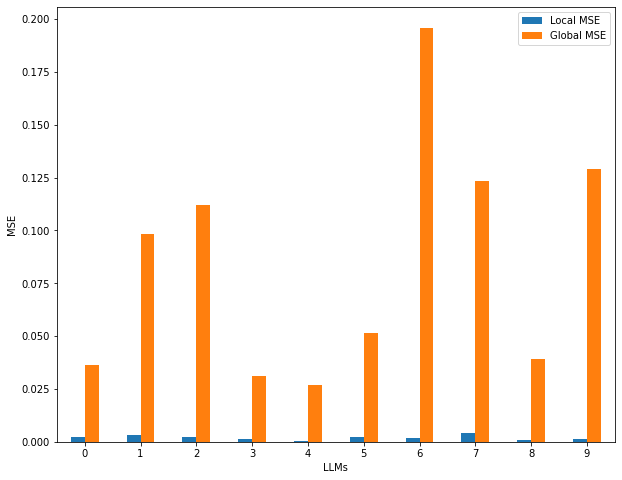

In [8]:
clf.diagperf_bar(nllms=10, figsize=(10, 8))

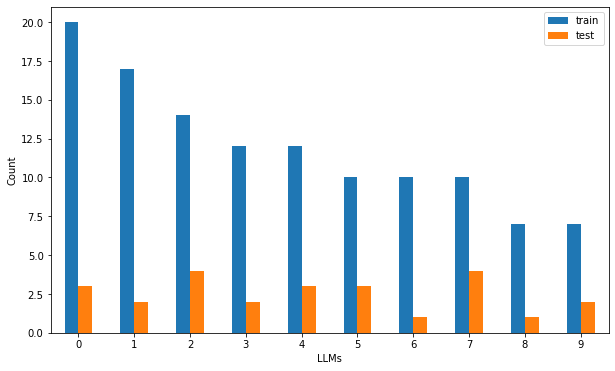

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,3.0,0.283704,0.085420,0.009080,0.048181
1,2.0,0.515556,0.108889,0.003941,0.090390
2,4.0,0.096111,0.069378,0.002094,0.098955
3,2.0,0.158889,0.043333,0.002824,0.043490
4,3.0,0.219259,0.048562,0.015653,0.024401
5,3.0,0.445185,0.050880,0.000190,0.069831
6,1.0,0.535556,0.000000,0.011531,0.190857
7,4.0,0.511667,0.152820,0.003741,0.144932
8,1.0,0.342222,0.000000,0.000527,0.038489
9,2.0,0.301111,0.054444,0.001559,0.114673


In [9]:
restable = clf.evaluate(test_x, test_y, vis=True, nllms=10)
restable

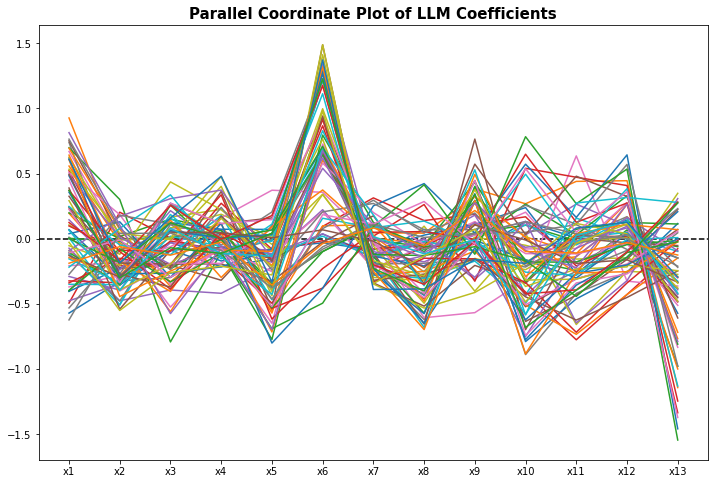

In [10]:
clf.pc_plot(figsize=(12, 8))

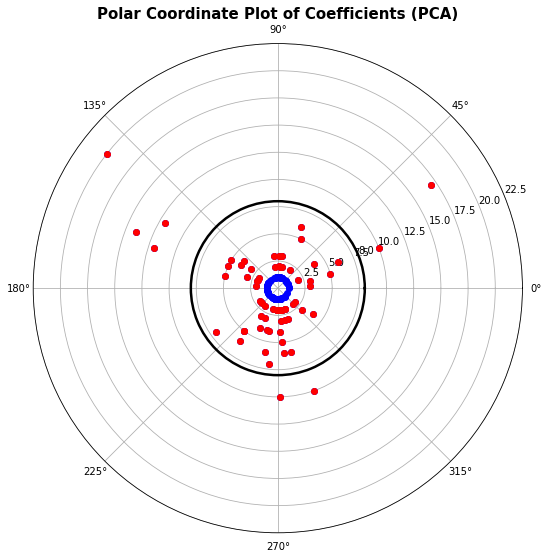

In [11]:
clf.polar_plot(min_samples=8, figsize=(9, 9))

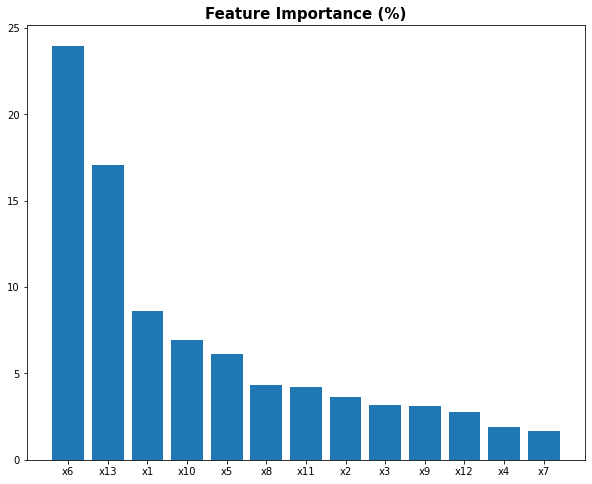

In [12]:
clf.feature_importance_plot(figsize=(10, 8))

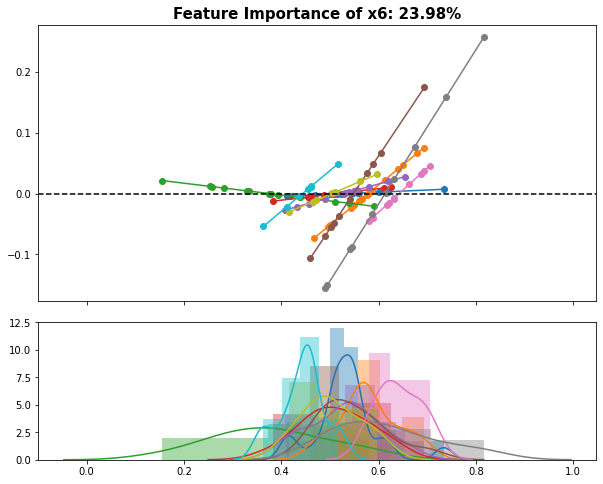

In [13]:
clf.profile_plot(feature_id=6, nllms=10, figsize=(10, 8))

# Simplification

In [14]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit

datanum = train_x.shape[0]
indices = np.arange(datanum)
idx1, idx2 = train_test_split(indices, test_size=0.2, random_state=random_state)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1

grid = GridSearchCV(MergerRegressor(unwrapper=None, 
                                     weights=mlp.coefs_, 
                                     biases=mlp.intercepts_,
                                     min_samples=30,
                                     n_neighbors=np.round(clf.nllms * 0.01).astype(int),
                                     refit_model=LassoCV()),
                                     param_grid={"n_clusters": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
                                     scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False)},
                                     cv=PredefinedSplit(val_fold), refit="mse", n_jobs=10, error_score=np.nan)
grid.fit(train_x, train_y)
clf_merge = grid.best_estimator_
clf_merge.summary()

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,88.0,0.513990,0.169048,0.003811,0.018443
1,81.0,0.516214,0.203825,0.004435,0.015651
2,68.0,0.295654,0.070866,0.001086,0.023485
3,64.0,0.409618,0.179413,0.004667,0.073450
4,56.0,0.316468,0.193315,0.007480,0.021852
5,47.0,0.149551,0.082505,0.002200,0.051552


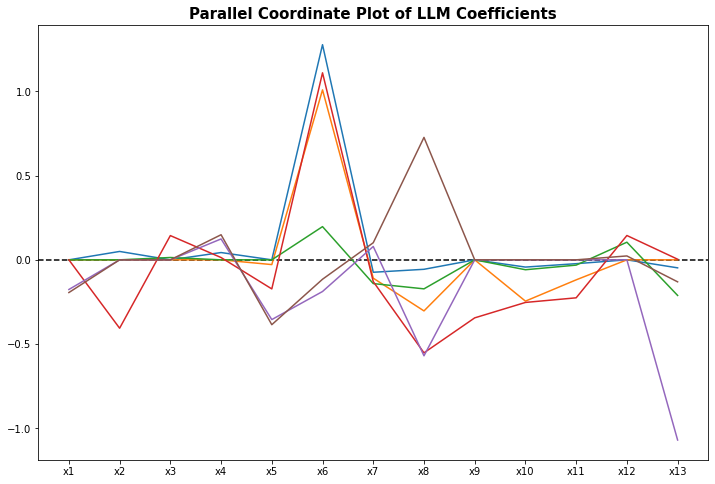

In [15]:
clf_merge.pc_plot(figsize=(12, 8))

Count            88.000000
Response Mean     0.513990
Response Std      0.169048
Local MSE         0.003811
Global MSE        0.018443
Name: 0, dtype: float64


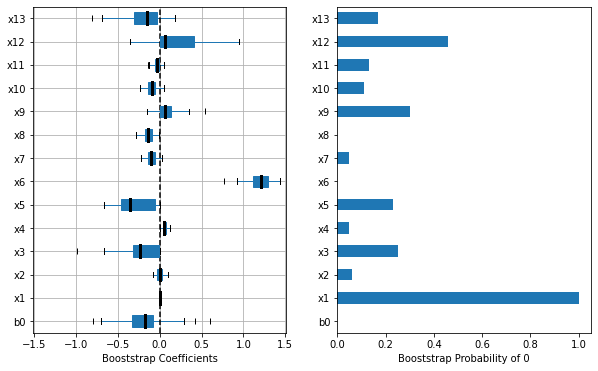

In [16]:
clf_merge.local_inference_booststrap(0)

In [17]:
clf_flatten = clf_merge.flatten(refit_model=LinearRegression())
clf_flatten.fit(train_x, train_y)

In [18]:
grid = GridSearchCV(PrunerRegressor(unwrapper=None, 
                                     weights=mlp.coefs_, 
                                     biases=mlp.intercepts_,
                                     topk=None,
                                     min_samples=0,
                                     refit_model=LassoCV()),
                                     param_grid={"n_clusters": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
                                     scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False)},
                                     cv=PredefinedSplit(val_fold), refit="mse", n_jobs=10, error_score=np.nan)
grid.fit(train_x, train_y)
clf_prune = grid.best_estimator_
clf_prune.summary()

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,201.0,0.502278,0.175663,0.004132,0.017115
1,100.0,0.324067,0.154392,0.003776,0.019898
2,57.0,0.319025,0.190430,0.007342,0.022149
3,24.0,0.152037,0.069912,0.001755,0.048423
4,22.0,0.132626,0.081193,0.001803,0.031950


In [19]:
train_stat = pd.DataFrame(np.hstack([mean_squared_error(train_y, mlp.predict(train_x)), 
           mean_squared_error(train_y, clf_merge.predict(train_x)),
           mean_squared_error(train_y, clf_flatten.predict(train_x)),
           mean_squared_error(train_y, clf_prune.predict(train_x))]).ravel(),
           index=["ReLU-Net", "Merge", "Flatten", "Prune"], columns=["train"]).T
test_stat = pd.DataFrame(np.hstack([mean_squared_error(test_y, mlp.predict(test_x)), 
           mean_squared_error(test_y, clf_merge.predict(test_x)),
           mean_squared_error(test_y, clf_flatten.predict(test_x)),
           mean_squared_error(test_y, clf_prune.predict(test_x))]).ravel(),
           index=["ReLU-Net", "Merge", "Flatten", "Prune"], columns=["test"]).T
pd.concat([train_stat, test_stat]).round(4)

,ReLU-Net,Merge,Flatten,Prune
train,0.0022,0.0039,0.0037,0.0042
test,0.0094,0.0092,0.0098,0.0093
